In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Processed Disorders.csv


In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from keras.optimizers import Adam

In [3]:
from keras_hub.tokenizers import compute_word_piece_vocabulary, WordPieceTokenizer
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/kaggle/input/dataset/Processed Disorders.csv')

In [7]:
df.head()

,content,label
0,life is so pointless without others : does any...,bpd
1,cold rage : hello fellow friends \n\ni'm on th...,bpd
2,i dont know who i am : my f20 bf m20 told me t...,bpd
3,"help opinions advice : okay, im about to open ...",bpd
4,my ex got diagnosed with bpd : without going i...,bpd


In [8]:
df.isna().any().any()

False

In [9]:
df['content'] = df['content'].apply(lambda text: text.replace('\n', ''))

In [10]:
classes = df['label'].unique()
ordinal = {label: i for i,label in enumerate(classes)}

In [11]:
df['label'] = df['label'].apply(lambda label: ordinal[label])

In [12]:
df['content'].apply(lambda x: len(x.split(' '))).describe()

count    543060.000000
mean        180.371557
std         197.997293
min           3.000000
25%          70.000000
50%         127.000000
75%         224.000000
max       20973.000000
Name: content, dtype: float64

In [13]:
df = df[df['content'].apply(len) <= 512]

In [14]:
df.head()

,content,label
0,life is so pointless without others : does any...,0
15,it hurts : it fucking hurtsit hurts it hurts i...,0
17,different between attachment and love : the ot...,0
22,what is the point of living when you have no o...,0
31,what kind of people do you find yourself attra...,0


In [15]:
train_df, other = train_test_split(
    df,
    test_size = 0.20,
    random_state = 86,
    stratify = df['label']
)

In [16]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.60,
    random_state = 86,
    stratify = other['label']
)

In [17]:
MAX_SEQLEN = 512

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_df['content'].values, train_df['label'].values
))

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    val_df['content'].values, val_df['label'].values
))

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    test_df['content'].values, test_df['label'].values
))

In [21]:
auto = tf.data.AUTOTUNE
print(len(train_df))

167916


In [22]:
BATCH_SIZE = 128
train_dataset = train_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
val_dataset = val_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
test_dataset = test_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)

In [23]:
def train_word_piece(ds, vocab_size=32000, reserved_tokens=["[PAD]", "[UNK]"]):
    word_piece = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece.batch(1024).prefetch(4),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens
    )
    return vocab

In [24]:
VOCAB = train_word_piece(train_dataset)

In [25]:
print("Tokens: ", VOCAB[100:110])

Tokens:  ['life', 'as', 'time', 'no', 'even', 'don', 'has', 'from', 'help', 'else']


In [26]:
tokenizer = WordPieceTokenizer(
    vocabulary=VOCAB,
    lowercase=False,
    sequence_length=MAX_SEQLEN
)

In [27]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'am i thinking irrationally pls someone answer quick : my boyfriend lives 13 min from my university apartment in same city and always picks me up because i dont drive  takes me to his place, dates, etc and today he said hes super tired and offer to uber split me to his place.. idk why i interpreted this as weird .. help', shape=(), dtype=string)
Tokens:  tf.Tensor(
[   86    26   229  4264  1220   126   878  1236    16    48   443   996
  1544  2959   107    48  1448  1531    57   264  1628    47   150  8308
    52    89    98    26    87   795   800    52    46   427   428     4
  3194     4   383    47   175   141   289   608   404   196    47  1511
    46  5402   955    52    46   427   428     5     5   283   137    26
 12121    59   101   321     5     5   108     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

In [28]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=auto)
    return dataset.shuffle(1024).prefetch(16).cache()

In [29]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [30]:
VOCAB_SIZE = 32000

In [31]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__() 
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [32]:
EMBED_DIM = 128
NUM_HEADS = 3
FF_DIM = 128

In [35]:
def Transformer():
    inputs = layers.Input(shape=(MAX_SEQLEN,), dtype="int", name="input_ids")
    embedding_layer = TokenAndPositionEmbedding(
        vocabulary_size=VOCAB_SIZE,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero = False,
    )
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(5, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)#, name="HuTao")
    return model

In [36]:
HuTao = Transformer()

In [37]:
HuTao.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 512, 128)            │       4,161,536 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 512, 128)            │         231,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,401,541 (16.79 MB)

 Trainable params: 4,401,541 (16.79 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=2,
)

In [39]:
modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'hutao.keras',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
)

In [40]:
HuTao.compile(
    optimizer = Adam(learning_rate = 3e-4), 
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [41]:
history = HuTao.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[earlyStopping])

Epoch 1/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 184s 129ms/step - accuracy: 0.4790 - loss: 1.1663 - val_accuracy: 0.7867 - val_loss: 0.5943
Epoch 2/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.7992 - loss: 0.5705 - val_accuracy: 0.7966 - val_loss: 0.5764
Epoch 3/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.8170 - loss: 0.5175 - val_accuracy: 0.7932 - val_loss: 0.5951
Epoch 4/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.8301 - loss: 0.4790 - val_accuracy: 0.7900 - val_loss: 0.6404
Epoch 5/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.8393 - loss: 0.4453 - val_accuracy: 0.7848 - val_loss: 0.7097
Epoch 6/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.8477 - loss: 0.4166 - val_accuracy: 0.7816 - val_loss: 0.7925
Epoch 7/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 164s 125ms/step - accuracy: 0.8540 - loss: 0.3932 - val_accuracy: 0.7789 - val_loss: 0.8893
Epoch 7: early stopping
Restoring model weights from the end o

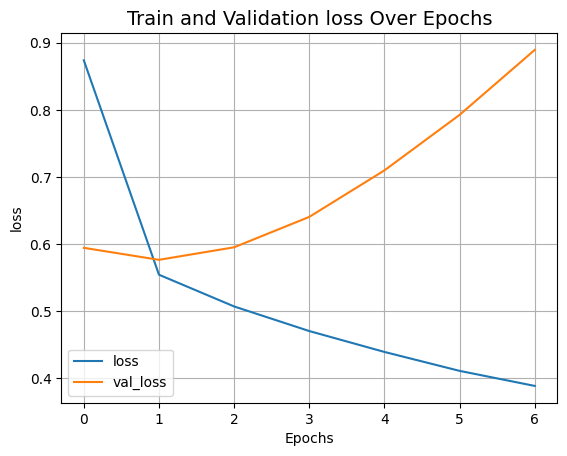

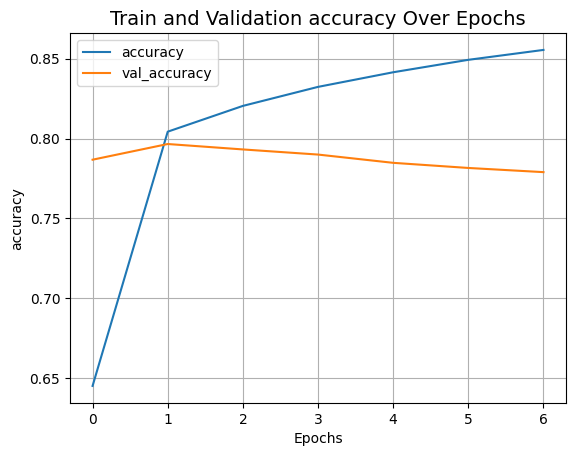

In [42]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [44]:
HuTao.evaluate(test_dataset, batch_size=BATCH_SIZE)

197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.7929 - loss: 0.5962


[0.5948665142059326, 0.794743537902832]